In [1]:
# config
import torch
import torch.nn as nn

# hyperparameters
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cpu') if gpu_id < 0 else torch.device('cuda:%d' % gpu_id)
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
batch_size = 64
hidden_size = 512
output_size = 1
num_head = 16
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
n_epochs = 1000
grad_acc = True
grad_acc_iter = 8

In [2]:
# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from utils import pid_diff_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID_DIFF(max_seq_len)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

In [3]:
# model
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F

# SeparableConv1D
class SeparableConv1D(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size):
        super().__init__()

        # input_filters = 512 <- hidden_size
        # output_filters = 256 <- all_attn_head_size

        self.depthwise = nn.Conv1d(input_filters, input_filters, kernel_size=kernel_size, groups=input_filters, padding=kernel_size //2, bias = False)
        self.pointwise = nn.Conv1d(input_filters, output_filters, kernel_size=1, bias=False)
        self.bias = nn.Parameter(torch.zeros(output_filters, 1))

        self.depthwise.weight.data.normal_(mean=0.0, std=0.02)
        self.pointwise.weight.data.normal_(mean=0.0, std=0.02)

    def forward(self, hidden_states):
        # |hidden_states| = (bs, hs, n)

        x = self.depthwise(hidden_states)
        # |x| = (bs, hs, n)

        x = self.pointwise(x)
        # |x| = (bs, hs/2(all_attn_h_size), n)

        x += self.bias
        # |x| = (bs, hs/2(all_attn_h_size), n)
        return x

# Thank for the Huggingface and Author of AKT
# Combined the Monotonic Attention and Span Dynamic Convolutional Attention
class MonotonicConvolutionalMultiheadAttention(nn.Module):
    # hidden % n_splits == 0
    def __init__(self, hidden_size, n_splits, dropout_p, head_ratio=2, conv_kernel_size=9):
        super().__init__()
        # default: n_splits = 16, head_ratio = 2
        
        new_num_attention_heads = n_splits // head_ratio
        self.num_attention_heads = new_num_attention_heads
        # default: self.new_num_attention_heads = 8

        self.head_ratio = head_ratio
        # default: self.head_ratio = 2

        self.conv_kernel_size = conv_kernel_size
        # default: self.conv_kernel_size = 9

        self.attention_head_size = hidden_size // n_splits
        # default: self.attention_head_size = 512//16 = 32

        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # default: self.all_head_size = 32 * 8 = 256

        # linear layers for query, key, value 
        self.query = nn.Linear(hidden_size, self.all_head_size, bias=False) # 512 -> 256
        self.key = nn.Linear(hidden_size, self.all_head_size, bias=False) # 512 -> 256
        self.value = nn.Linear(hidden_size, self.all_head_size, bias=False) # 512 -> 256

        # layers for span dynamic convolutional attention
        self.key_conv_attn_layer = SeparableConv1D(
            hidden_size, self.all_head_size, self.conv_kernel_size
        )
        self.conv_kernel_layer = nn.Linear(self.all_head_size, 
                                        self.num_attention_heads * self.conv_kernel_size # 8 * 9 = 72
                                        )
        self.conv_out_layer = nn.Linear(hidden_size, self.all_head_size)

        self.unfold = nn.Unfold(
            kernel_size=[self.conv_kernel_size, 1], padding=[int((self.conv_kernel_size - 1) / 2), 0]
        )
        
        # this is for the distance function
        self.gammas = nn.Parameter(torch.zeros(self.num_attention_heads, 1, 1))

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, Q, K, V, mask=None):
        # |Q| = |K| = |V| = (bs, n, hs)
        # |mask| = (bs, n)

        batch_size = Q.size(0)

        mixed_query_layer = self.query(Q)
        mixed_key_layer = self.key(K)
        mixed_value_layer = self.value(V)
        # |mixed_query_layer| = |mixed_key_layer| = |mixed_value_layer| = (bs, n, hs/2(all_attn_h_size))

        mixed_key_conv_attn_layer = self.key_conv_attn_layer(
            K.transpose(1, 2) # |hidden_states.transpose(1, 2)| = (bs, hs, n)
        )
        # |mixed_key_conv_attn_layer| = (bs, hs/2(all_attn_h_size), n)
        mixed_key_conv_attn_layer = mixed_key_conv_attn_layer.transpose(1, 2)
        # |mixed_key_conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))

        query_layer = self.transpose_for_scores(mixed_query_layer)
        # |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        # |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        # |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)

        ##############
        # conv layer #
        ##############
        # element-wise multiply of conv key and query 
        conv_attn_layer = torch.multiply(mixed_key_conv_attn_layer, mixed_query_layer)
        # |conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))
        conv_kernel_layer = self.conv_kernel_layer(conv_attn_layer)
        # |conv_kernel_layer| = (bs, n, (n_attn_h * conv_kernel_size) = (64, 100, 8 * 9) = (64, 100, 72)
        conv_kernel_layer = torch.reshape(conv_kernel_layer, [-1, self.conv_kernel_size, 1])
        # |conv_kernel_layer| = (51200, 9, 1)
        conv_kernel_layer = torch.softmax(conv_kernel_layer, dim=1)
        # |conv_kernel_layer| = (51200, 9, 1), 각 head별 확률값들을 도출하는 듯

        # q X k is matmul with v
        conv_out_layer = self.conv_out_layer(V)
        # |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
        conv_out_layer = torch.reshape(conv_out_layer, [batch_size, -1, self.all_head_size])
        # |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
        conv_out_layer = conv_out_layer.transpose(1, 2).contiguous().unsqueeze(-1)
        # |conv_out_layer| = (bs, hs/2(all_attn_h_size), n, 1)
        # unfold 참고 -> #https://www.facebook.com/groups/PyTorchKR/posts/1685133764959631/
        conv_out_layer = nn.functional.unfold( 
            conv_out_layer,
            kernel_size=[self.conv_kernel_size, 1],
            dilation=1,
            padding=[(self.conv_kernel_size - 1) // 2, 0],
            stride=1,
        )
        # |conv_out_layer| = (64, 2304, 100)
        conv_out_layer = conv_out_layer.transpose(1, 2).reshape(
            batch_size, -1, self.all_head_size, self.conv_kernel_size
        )
        # |conv_out_layer| = (bs, n, hs/2(all_attn_h_size), conv_kernal_size)
        conv_out_layer = torch.reshape(conv_out_layer, [-1, self.attention_head_size, self.conv_kernel_size])
        # |conv_out_layer|, default = (51200, 32, 9)
        # matmul(q X k, v)
        conv_out_layer = torch.matmul(conv_out_layer, conv_kernel_layer)
        # |conv_out_layer|, default = (51200, 32, 1)
        conv_out_layer = torch.reshape(conv_out_layer, [-1, self.all_head_size])
        # |conv_out_layer|, default = (6400, 256)

        ###################
        # self_attn layer #
        ###################
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        # |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

        #####################
        # distance function #
        #####################
        dist_scores = self.dist_func(attention_scores, mask)
        # |dist_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        m = nn.Softplus()
        # gamma is learnable decay rate parameter
        gamma = -1.0 * m(self.gammas).unsqueeze(0)
        # Now after do exp(gamma * distance) and then clamp to 1e-5 to 1e-5
        total_effect = torch.clamp(
            torch.clamp((dist_scores * gamma).exp(), min=1e-5), max=1e5
        )
        # |total_effect| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

        attention_scores = attention_scores * total_effect
        # |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

        # |mask| = (bs, n)
        attention_mask = self.get_extended_attention_mask(mask)
        # |attention_mask| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        attention_scores = attention_scores.masked_fill_(attention_mask==0, -1e8)
        # |attention_scores| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        # |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)
        attention_probs = self.dropout(attention_probs)
        # |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

        context_layer = torch.matmul(attention_probs, value_layer)
        # |context_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        # |context_layer| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)
        
        #########################################
        # concat with conv and self_attn values #
        #########################################
        conv_out = torch.reshape(conv_out_layer, [batch_size, -1, self.num_attention_heads, self.attention_head_size])
        # |conv_out| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)
        context_layer = torch.cat([context_layer, conv_out], 2)
        # |context_layer| = (bs, n, n_attn_head * 2, attn_head_size) = (64, 100, 16, 32)
        new_context_layer_shape = context_layer.size()[:-2] + \
             (self.head_ratio * self.all_head_size,)
        # new_context_layer_shape = (bs, n, hs)
        context_layer = context_layer.view(*new_context_layer_shape)
        # |context_layer| = (bs, n, hs)

        outputs = context_layer
        # |context_layer| = (bs, n, hs)
        # if you need attention_probs, add the return
        # |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

        # |outputs| = (bs, n, hs)
        return outputs, attention_probs

    # Thanks for the AKT's author and Upstage
    # this is the distance function, this function don't use grad
    @torch.no_grad()
    def dist_func(self, attention_scores, mask):

        scores = attention_scores
        bs, head, seqlen = scores.size(0), scores.size(1), scores.size(2)

        x1 = torch.arange(seqlen).expand(seqlen, -1)
        x2 = x1.transpose(0, 1).contiguous()

        attention_mask = self.get_extended_attention_mask(mask)

        scores_ = scores.masked_fill_(attention_mask == 0, -1e32)

        scores_ = F.softmax(scores_, dim=-1)
        scores_ = scores_ * attention_mask.float()

        distcum_scores = torch.cumsum(scores_, dim=-1)
        disttotal_scores = torch.sum(scores_, dim=-1, keepdim=True)
        """
        >>> x1-x2
            tensor([[ 0,  1,  2,  3,  4],
                    [-1,  0,  1,  2,  3],
                    [-2, -1,  0,  1,  2],
                    [-3, -2, -1,  0,  1],
                    [-4, -3, -2, -1,  0]])

        >>> torch.abs(x1-x2)
            tensor([[0, 1, 2, 3, 4],
                    [1, 0, 1, 2, 3],
                    [2, 1, 0, 1, 2],
                    [3, 2, 1, 0, 1],
                    [4, 3, 2, 1, 0]])
        """     
        device = distcum_scores.get_device()
        position_effect = torch.abs(x1 - x2)[None, None, :, :].type(
            torch.FloatTensor
        ) 
        # |position_effect| = (1, 1, seqlen, seqlen)
        position_effect = position_effect.to(device)
        
        # dist_score => d(t, tau)
        dist_scores = torch.clamp(
            (disttotal_scores - distcum_scores) * position_effect, min=0.0
        )

        dist_scores = dist_scores.sqrt().detach()

        # |dist_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
        return dist_scores

    # this is for attention mask
    @torch.no_grad()
    def get_extended_attention_mask(self, mask):
        # |mask| = (bs, n)
        mask_shape = mask.size() + (mask.size(1), self.num_attention_heads)
        # mask_shape = (bs, n, n, n_attn_head)
        mask_enc = mask.unsqueeze(-1).expand(mask.size(0), mask.size(1), mask.size(1) * self.num_attention_heads).bool()
        # |mask_enc| = (bs, n, n * n_attn_head)

        mask_enc = mask_enc.view(*mask_shape)
        # |mask_enc| = (bs, n, n, n_attn_head), default = (64, 100, 100, 8)

        return mask_enc.permute(0, 3, 2, 1)
        # |mask_enc| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

    # for attention, last dim will be divied to n_attn_head, and get a new shape
    def transpose_for_scores(self, x):
        # |x| = (bs, n, hs/2(all_attn_h_size))

        # 마지막 차원을 n_attn_head의 수만큼으로 나눔
        new_x_shape = x.size()[:-1] + \
             (self.num_attention_heads, self.attention_head_size)
        # |x.size()[:-1]| = (bs, n)
        # self.new_num_attention_heads = 8
        # self.attention_head_size = 32
        # |new_x_shape| = (bs, n, new_num_attention_heads, attention_head_size)

        x = x.view(*new_x_shape)
        # |x| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)

        return x.permute(0, 2, 1, 3)
        # |x| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)


class EncoderBlock(nn.Module):

    def __init__(
        self,
        hidden_size, # default = 512
        n_splits,
        use_leakyrelu,
        max_seq_len,
        dropout_p=.1,
    ):
        super().__init__()

        self.use_leakyrelu = use_leakyrelu

        self.attn = MonotonicConvolutionalMultiheadAttention(hidden_size, n_splits, dropout_p)
        self.attn_norm = nn.LayerNorm(hidden_size)
        self.attn_dropout = nn.Dropout(dropout_p)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            # if you want to use gelu, then you have to change config option
            nn.LeakyReLU() if self.use_leakyrelu else self.gelu(),
            nn.Linear(hidden_size * 4, hidden_size),
        )
        self.fc_norm = nn.LayerNorm(hidden_size)
        self.fc_dropout = nn.Dropout(dropout_p)

    def forward(self, x, mask, attn_probs):
        # |x| = (bs, n, emb_size), torch.float32
        # |mask| = (bs, n, n)

        # Pre-LN:
        z = self.attn_norm(x)
        # |z| = (bs, n, emb_size)

        attn_outputs, attn_probs = self.attn(Q=z, K=z, V=z, mask=mask)

        # x+ means redisual connection
        z = x + self.attn_dropout(attn_outputs)
        # |z| = (bs, n, hs)

        z = z + self.fc_dropout(self.fc(self.fc_norm(z)))
        # |z| = (bs, n, hs)

        return z, mask, attn_probs

    # Thanks for the upstage
    # upstage's gelu
    def gelu(x):
        """Upstage said:
            Implementation of the gelu activation function.
            For information: OpenAI GPT's gelu is slightly different
            (and gives slightly different results):
            0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) *
            (x + 0.044715 * torch.pow(x, 3))))
            Also see https://arxiv.org/abs/1606.08415
        """
        return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

# Thanks for the Kihyeon Kim
class MySequential(nn.Sequential):
    # New Sequential function
    # this can handle the tuple also
    def forward(self, *x):
        # nn.Sequential class does not provide multiple input arguments and returns.
        # Thus, we need to define new class to solve this issue.
        # Note that each block has same function interface.

        for module in self._modules.values():
            x = module(*x)

        return x

# This is the main model
class MonaConvBert4ktPlusDiff(nn.Module):

    def __init__(
        self,
        num_q,
        num_r,
        num_pid,
        num_diff,
        hidden_size,
        output_size,
        num_head,
        num_encoder,
        max_seq_len,
        device,
        use_leakyrelu,
        dropout_p=.1,
    ):
        self.num_q = num_q
        self.num_r = num_r + 2 # '+2' is for 1(correct), 0(incorrect), <PAD>, <MASK>
        self.num_pid = num_pid
        self.num_diff = 101 # hard coding

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_head = num_head
        self.num_encoder = num_encoder
        self.max_seq_len = max_seq_len
        self.device = device
        self.use_leakyrelu = use_leakyrelu
        self.dropout_p = dropout_p

        super().__init__()

        # question embedding
        self.emb_q = nn.Embedding(self.num_q, self.hidden_size).to(self.device)
        # response embedding
        self.emb_r = nn.Embedding(self.num_r, self.hidden_size).to(self.device)
        # positional embedding
        self.emb_pid = nn.Embedding(self.num_pid, self.hidden_size).to(self.device)

        self.emb_diff = nn.Embedding(self.num_diff, self.hidden_size).to(self.device)

        self.emb_p = nn.Embedding(self.max_seq_len, self.hidden_size).to(self.device)
        self.emb_dropout = nn.Dropout(self.dropout_p)

        # Using MySequential
        self.encoder = nn.ModuleList(
            [EncoderBlock(
                hidden_size,
                num_head,
                self.use_leakyrelu,
                self.max_seq_len,
                dropout_p,
            ) for _ in range(num_encoder)],
        )

        self.generator = nn.Sequential(
            nn.LayerNorm(hidden_size), # Only for Pre-LN Transformer.
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid() # Binary
        )

    # Learnable Positional embedding
    def _positional_embedding(self, q):
        # |q| = (bs, n)
        # |r| = (bs, n)
        seq_len = q.size(1)
        # seq_len = (n,)
        pos = torch.arange(seq_len, dtype=torch.long).unsqueeze(0).expand_as(q).to(self.device)
        # |pos| = (bs, n)
        
        pos_emb = self.emb_p(pos)
        # |emb| = (bs, n, hs)

        return pos_emb

    def forward(self, q, r, pid, diff, mask):
        # |q| = (bs, n)
        # |r| = (bs, n)
        # |mask| = (bs, n)

        emb = self.emb_q(q) + self.emb_r(r) + self.emb_pid(pid) + self.emb_diff(diff) + self._positional_embedding(q)
        # |emb| = (bs, n, emb_size)

        z = self.emb_dropout(emb)
        # |z| = (bs, n, emb_size)

        # |mask_enc| = (bs, n, n)
        # |z| = (bs, n, emb_size)
        attn_probs = None

        for block in self.encoder:
            z, _, attn_probs = block(z, mask, attn_probs)

        y_hat = self.generator(z)
        #|y_hat| = (bs, n, output_size=1)

        return y_hat, attn_probs

In [4]:
model = MonaConvBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=num_head,
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
    ).to(device)

In [5]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [6]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Train MLM
# 15% <MASK>, 80% of 15% are real <MASK>, 10% of 15% are reverse, 10% of 15% are not changed
def Mlm4BertTrain(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    # <PAD> is -1
    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)
        # real_r_seq: r_seq with no <PAD>
        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        mlm_idx = np.random.choice(real_r_seq_len, int(real_r_seq_len*0.15), replace=False)

        for idx in mlm_idx:
            if random() < 0.8: # 15% of 80% are <MASK>
                real_r_seq[idx] = 2 # <MASK> is 2
            elif random() < 0.5: # 15% of 10% are random among the 0 or 1
                real_r_seq[idx] = randint(0, 1)
            # 15% of 10% are same with original

        # cover the PAD(-1)
        pad_len = r_len - real_r_seq_len
        # <PAD> is 3
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) 
        # combine the <PAD>
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        # append to the mlm_r_seqs
        mlm_r_seqs.append(pad_r_seq)

        # <MASK> idx bool
        # make zero vector with r_len size
        mlm_zeros = np.zeros(shape=(r_len, ))
        # mlm_idx are 1
        mlm_zeros[mlm_idx] = 1
        # append to the mlm_idxs
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    # mlm_r_seqs: masked r_seqs
    # mlm_idx: masked idx
    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class MonaConvBert4ktPlusDiffTrainer():

    def __init__(
        self, 
        model, 
        optimizer, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
    
    def _train(self, train_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        for idx, data in enumerate(tqdm(train_loader)):
            self.model.train()
            q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

            q_seqs = q_seqs.to(self.device) # |q_seqs| = (bs, n)
            r_seqs = r_seqs.to(self.device) # |r_seqs| = (bs, n)
            pid_seqs = pid_seqs.to(self.device) # |pid_seqs| = (bs, n)
            diff_seqs = diff_seqs.to(self.device)
            mask_seqs = mask_seqs.to(self.device) # |mask_seqs| = (bs, n)

            # for correct
            real_seqs = r_seqs.clone()

            # mlm_r_seqs: for MLM, [MASK] position get 2 / mlm_idx are index of [MASK]
            mlm_r_seqs, mlm_idxs = Mlm4BertTrain(r_seqs, mask_seqs)
            # |mlm_r_seqs| = (bs, n)
            # |mlm_idxs| = (bs, n)
            mlm_r_seqs = mlm_r_seqs.to(self.device)
            mlm_idxs = mlm_idxs.to(self.device)

            y_hat, attn_probs = self.model(
                q_seqs.long(), 
                mlm_r_seqs.long(), # r_seqs with MLM
                pid_seqs.long(),
                diff_seqs.long(),
                mask_seqs.long() # for attn_mask
            )
            # |y_hat| = (bs, n, output_size=1)

            y_hat = y_hat.squeeze()
             # |y_hat| = (bs, n)

            # predictions
            y_hat = torch.masked_select(y_hat, mlm_idxs)
            #|y_hat| = (bs * n - n_mlm_idxs)
            # real values
            correct = torch.masked_select(real_seqs, mlm_idxs)
            #|correct| = (bs * n - n_mlm_idxs)

            loss = self.crit(y_hat, correct)
            # |loss| = (1)

            # grad_accumulation = True
            if self.grad_acc == True:
                loss.backward()
                if (idx + 1) % self.grad_acc_iter == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            # grad_accumulation = False
            else:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            y_trues.append(correct)
            y_scores.append(y_hat)
            loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

    def _validate(self, valid_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(valid_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat, attn_probs = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                loss = self.crit(y_hat, correct)

                y_trues.append(correct)
                y_scores.append(y_hat)
                loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

    def _test(self, test_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat, attn_probs = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                loss = self.crit(y_hat, correct)

                y_trues.append(correct)
                y_scores.append(y_hat)
                loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score, attn_probs

    # train use the _train, _validate, _test
    def train(self, train_loader, valid_loader, test_loader):
        
        best_valid_score = 0
        train_scores = []
        valid_scores = []

        # early_stopping
        early_stopping = EarlyStopping(metric_name="AUC",
                                    best_score=best_valid_score)

        # Train and Valid Session
        for epoch_index in range(self.n_epochs):
            
            print("Epoch(%d/%d) start" % (
                epoch_index + 1,
                self.n_epochs
            ))

            # Training Session
            train_score = self._train(train_loader)
            valid_score = self._validate(valid_loader)

            # train, test record 저장
            train_scores.append(train_score)
            valid_scores.append(valid_score)

            # early stop
            train_scores_avg = np.average(train_scores)
            valid_scores_avg = np.average(valid_scores)
            early_stopping(valid_scores_avg, self.model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            print("Epoch(%d/%d) result: train_score=%.4f  valid_score=%.4f" % (
                epoch_index + 1,
                self.n_epochs,
                train_score,
                valid_score
            ))


        test_score, attn_probs = self._test(test_loader)

        return attn_probs

In [7]:
trainer = MonaConvBert4ktPlusDiffTrainer(
    model=model,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
    num_q=num_q,
    crit=crit,
    max_seq_len=max_seq_len,
    grad_acc=grad_acc,
    grad_acc_iter=grad_acc_iter
)

In [8]:
attn_probs = trainer.train(train_loader, valid_loader, test_loader)
attn_probs.size()

Epoch(1/1000) start


  0%|          | 0/61 [00:00<?, ?it/s]/tmp/ipykernel_426807/248469530.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:203.)
  mlm_idxs = torch.BoolTensor(mlm_idxs)
100%|██████████| 7/7 [00:00<00:00,  7.70it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.000000 --> 0.659983).  Saving model ...
Epoch(1/1000) result: train_score=0.5222  valid_score=0.6600
Epoch(2/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.67it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.659983 --> 0.682080).  Saving model ...
Epoch(2/1000) result: train_score=0.5338  valid_score=0.7042
Epoch(3/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.63it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.682080 --> 0.698234).  Saving model ...
Epoch(3/1000) result: train_score=0.5435  valid_score=0.7305
Epoch(4/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.61it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.698234 --> 0.716210).  Saving model ...
Epoch(4/1000) result: train_score=0.6224  valid_score=0.7701
Epoch(5/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.56it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.716210 --> 0.735737).  Saving model ...
Epoch(5/1000) result: train_score=0.7370  valid_score=0.8138
Epoch(6/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.57it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.735737 --> 0.750223).  Saving model ...
Epoch(6/1000) result: train_score=0.7592  valid_score=0.8227
Epoch(7/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.54it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.750223 --> 0.761378).  Saving model ...
Epoch(7/1000) result: train_score=0.7768  valid_score=0.8283
Epoch(8/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.52it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.761378 --> 0.771257).  Saving model ...
Epoch(8/1000) result: train_score=0.8037  valid_score=0.8404
Epoch(9/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.47it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.771257 --> 0.779421).  Saving model ...
Epoch(9/1000) result: train_score=0.8095  valid_score=0.8447
Epoch(10/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.779421 --> 0.786334).  Saving model ...
Epoch(10/1000) result: train_score=0.8191  valid_score=0.8485
Epoch(11/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.786334 --> 0.792211).  Saving model ...
Epoch(11/1000) result: train_score=0.8211  valid_score=0.8510
Epoch(12/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.792211 --> 0.796781).  Saving model ...
Epoch(12/1000) result: train_score=0.8257  valid_score=0.8470
Epoch(13/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.796781 --> 0.801018).  Saving model ...
Epoch(13/1000) result: train_score=0.8304  valid_score=0.8519
Epoch(14/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.801018 --> 0.804729).  Saving model ...
Epoch(14/1000) result: train_score=0.8294  valid_score=0.8530
Epoch(15/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.804729 --> 0.808218).  Saving model ...
Epoch(15/1000) result: train_score=0.8315  valid_score=0.8571
Epoch(16/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.808218 --> 0.811501).  Saving model ...
Epoch(16/1000) result: train_score=0.8348  valid_score=0.8607
Epoch(17/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.811501 --> 0.814461).  Saving model ...
Epoch(17/1000) result: train_score=0.8361  valid_score=0.8618
Epoch(18/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.814461 --> 0.817147).  Saving model ...
Epoch(18/1000) result: train_score=0.8427  valid_score=0.8628
Epoch(19/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.817147 --> 0.819771).  Saving model ...
Epoch(19/1000) result: train_score=0.8402  valid_score=0.8670
Epoch(20/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.819771 --> 0.822062).  Saving model ...
Epoch(20/1000) result: train_score=0.8420  valid_score=0.8656
Epoch(21/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.822062 --> 0.824013).  Saving model ...
Epoch(21/1000) result: train_score=0.8414  valid_score=0.8630
Epoch(22/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.824013 --> 0.825922).  Saving model ...
Epoch(22/1000) result: train_score=0.8443  valid_score=0.8660
Epoch(23/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.825922 --> 0.827658).  Saving model ...
Epoch(23/1000) result: train_score=0.8496  valid_score=0.8658
Epoch(24/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.827658 --> 0.829212).  Saving model ...
Epoch(24/1000) result: train_score=0.8486  valid_score=0.8650
Epoch(25/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.829212 --> 0.830601).  Saving model ...
Epoch(25/1000) result: train_score=0.8547  valid_score=0.8639
Epoch(26/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.830601 --> 0.831866).  Saving model ...
Epoch(26/1000) result: train_score=0.8563  valid_score=0.8635
Epoch(27/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.831866 --> 0.833088).  Saving model ...
Epoch(27/1000) result: train_score=0.8584  valid_score=0.8649
Epoch(28/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.833088 --> 0.834139).  Saving model ...
Epoch(28/1000) result: train_score=0.8612  valid_score=0.8625
Epoch(29/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.834139 --> 0.834993).  Saving model ...
Epoch(29/1000) result: train_score=0.8623  valid_score=0.8589
Epoch(30/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.834993 --> 0.835809).  Saving model ...
Epoch(30/1000) result: train_score=0.8662  valid_score=0.8595
Epoch(31/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.835809 --> 0.836360).  Saving model ...
Epoch(31/1000) result: train_score=0.8686  valid_score=0.8529
Epoch(32/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.836360 --> 0.837220).  Saving model ...
Epoch(32/1000) result: train_score=0.8703  valid_score=0.8639
Epoch(33/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.837220 --> 0.838139).  Saving model ...
Epoch(33/1000) result: train_score=0.8721  valid_score=0.8675
Epoch(34/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.838139 --> 0.838998).  Saving model ...
Epoch(34/1000) result: train_score=0.8781  valid_score=0.8673
Epoch(35/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.838998 --> 0.839727).  Saving model ...
Epoch(35/1000) result: train_score=0.8763  valid_score=0.8645
Epoch(36/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.839727 --> 0.840347).  Saving model ...
Epoch(36/1000) result: train_score=0.8855  valid_score=0.8620
Epoch(37/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.840347 --> 0.840639).  Saving model ...
Epoch(37/1000) result: train_score=0.8863  valid_score=0.8512
Epoch(38/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.840639 --> 0.840951).  Saving model ...
Epoch(38/1000) result: train_score=0.8910  valid_score=0.8525
Epoch(39/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.840951 --> 0.841238).  Saving model ...
Epoch(39/1000) result: train_score=0.8950  valid_score=0.8522
Epoch(40/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.45it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.841238 --> 0.841654).  Saving model ...
Epoch(40/1000) result: train_score=0.8957  valid_score=0.8579
Epoch(41/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.841654 --> 0.841980).  Saving model ...
Epoch(41/1000) result: train_score=0.9014  valid_score=0.8550
Epoch(42/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.841980 --> 0.842448).  Saving model ...
Epoch(42/1000) result: train_score=0.8994  valid_score=0.8616
Epoch(43/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.842448 --> 0.842765).  Saving model ...
Epoch(43/1000) result: train_score=0.9052  valid_score=0.8561
Epoch(44/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.842765 --> 0.843144).  Saving model ...
Epoch(44/1000) result: train_score=0.9048  valid_score=0.8594
Epoch(45/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843144 --> 0.843379).  Saving model ...
Epoch(45/1000) result: train_score=0.9076  valid_score=0.8537
Epoch(46/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843379 --> 0.843605).  Saving model ...
Epoch(46/1000) result: train_score=0.9060  valid_score=0.8538
Epoch(47/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


EarlyStopping counter: 1 out of 10
Epoch(47/1000) result: train_score=0.9132  valid_score=0.8424
Epoch(48/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843605 --> 0.843841).  Saving model ...
Epoch(48/1000) result: train_score=0.9126  valid_score=0.8561
Epoch(49/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843841 --> 0.843889).  Saving model ...
Epoch(49/1000) result: train_score=0.9135  valid_score=0.8462
Epoch(50/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843889 --> 0.843895).  Saving model ...
Epoch(50/1000) result: train_score=0.9180  valid_score=0.8442
Epoch(51/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


EarlyStopping counter: 1 out of 10
Epoch(51/1000) result: train_score=0.9204  valid_score=0.8411
Epoch(52/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843895 --> 0.843921).  Saving model ...
Epoch(52/1000) result: train_score=0.9241  valid_score=0.8480
Epoch(53/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Validation loss was updated (0.843921 --> 0.843965).  Saving model ...
Epoch(53/1000) result: train_score=0.9259  valid_score=0.8463
Epoch(54/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


EarlyStopping counter: 1 out of 10
Epoch(54/1000) result: train_score=0.9282  valid_score=0.8437
Epoch(55/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


EarlyStopping counter: 2 out of 10
Epoch(55/1000) result: train_score=0.9280  valid_score=0.8439
Epoch(56/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


EarlyStopping counter: 3 out of 10
Epoch(56/1000) result: train_score=0.9299  valid_score=0.8436
Epoch(57/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


EarlyStopping counter: 4 out of 10
Epoch(57/1000) result: train_score=0.9323  valid_score=0.8411
Epoch(58/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


EarlyStopping counter: 5 out of 10
Epoch(58/1000) result: train_score=0.9348  valid_score=0.8305
Epoch(59/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


EarlyStopping counter: 6 out of 10
Epoch(59/1000) result: train_score=0.9361  valid_score=0.8373
Epoch(60/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


EarlyStopping counter: 7 out of 10
Epoch(60/1000) result: train_score=0.9366  valid_score=0.8356
Epoch(61/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


EarlyStopping counter: 8 out of 10
Epoch(61/1000) result: train_score=0.9384  valid_score=0.8362
Epoch(62/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


EarlyStopping counter: 9 out of 10
Epoch(62/1000) result: train_score=0.9423  valid_score=0.8227
Epoch(63/1000) start


100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


EarlyStopping counter: 10 out of 10
Early stopping


100%|██████████| 17/17 [00:02<00:00,  7.19it/s]


torch.Size([57, 8, 100, 100])

In [9]:
attn_probs[0][0].size()

torch.Size([100, 100])

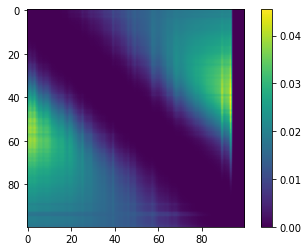

In [23]:
# 시각화

import matplotlib.pyplot as plt

score = attn_probs[0][0]
score = score.detach().cpu().numpy()

plt.viridis()
plt.imshow(score)
plt.colorbar()

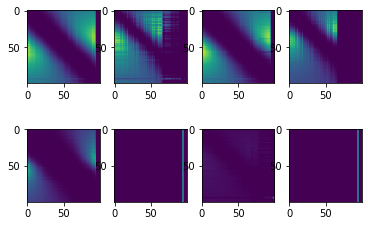

<Figure size 1440x576 with 0 Axes>

In [26]:
for i in range(8):
    score = attn_probs[0][i]
    score = score.detach().cpu().numpy()
    plt.subplot(2,4,i+1)
    plt.viridis()
    plt.imshow(score)
    

plt.figure(figsize=(20, 8))
plt.show()

In [13]:
import pickle

attn_path = "../visual_records/attn_data.pkl"

# pickfile save
with open(attn_path, "wb") as f:
    pickle.dump(attn_probs, f)


In [14]:
# pickfile load
with open(attn_path, "rb") as f:
    attn_probs2 = pickle.load(f)

tensor([[[[7.6582e-34, 2.3946e-15, 1.0785e-12,  ..., 7.8275e-34,
           3.7626e-33, 0.0000e+00],
          [1.1454e-16, 2.3884e-25, 1.2208e-14,  ..., 1.0138e-30,
           5.3702e-30, 0.0000e+00],
          [1.2647e-13, 1.6880e-14, 6.2945e-28,  ..., 4.6295e-32,
           2.5103e-31, 0.0000e+00],
          ...,
          [1.9167e-02, 1.9410e-02, 1.9280e-02,  ..., 9.0014e-34,
           4.2550e-33, 0.0000e+00],
          [1.8811e-02, 1.9039e-02, 1.8917e-02,  ..., 1.6532e-33,
           7.6494e-33, 0.0000e+00],
          [1.7949e-02, 1.8124e-02, 1.8026e-02,  ..., 3.7908e-30,
           1.2420e-29, 0.0000e+00]],

         [[7.0147e-13, 2.2313e-09, 1.5930e-07,  ..., 1.0178e-13,
           2.7705e-14, 0.0000e+00],
          [1.5196e-05, 1.2326e-11, 6.1090e-07,  ..., 4.5778e-09,
           1.0178e-09, 0.0000e+00],
          [4.4431e-05, 1.4020e-07, 1.9412e-12,  ..., 4.5401e-10,
           1.0898e-10, 0.0000e+00],
          ...,
          [1.7883e-02, 1.7672e-02, 1.7661e-02,  ..., 3.1899